In [5]:
import pickle
from random import sample

# PB: prediction based algorithm
# RB: response based algoritm


file_name_PB = "data/vision_forward_graph_data_08_09_22.pkl"
with open(file_name_PB, 'rb') as f:
    df_PB = pickle.load(f)
    #df_PB.sort_values(by="platform", inplace=True, ignore_index=True)

file_name_RB = "data/vision_graph_data_remote_23_08_22.pkl"
with open(file_name_RB, 'rb') as f:
    df_RB = pickle.load(f)

file_name_baseline = "data/vision_baseline_graph_data_24_08_22.pkl"
with open(file_name_RB, 'rb') as f:
    df_baseline = pickle.load(f)

file_name_centrality = "data/author_centrality_remote.pkl"
with open(file_name_centrality, 'rb') as f:
    df_centrality = pickle.load(f)

common_conversation_ids = set(df_PB.conversation_id).intersection(df_RB.conversation_id).intersection(
    df_centrality.conversation_id).intersection(df_baseline.conversation_id)
all_conversation_ids = set(df_PB.conversation_id).union(df_RB.conversation_id).union(
    df_centrality.conversation_id).union(df_baseline.conversation_id)
all_conversation_count = len(all_conversation_ids)
common_conversation_count = len(common_conversation_ids)
# reducing the sample size for testing
common_conversation_ids = sample(common_conversation_ids, 200)

print("From {} conversations {} are shared in all datasets".format(all_conversation_count, common_conversation_count))

df_PB = df_PB[df_PB.conversation_id.isin(common_conversation_ids)]
df_RB = df_RB[df_RB.conversation_id.isin(common_conversation_ids)]
df_centrality = df_centrality[df_centrality.conversation_id.isin(common_conversation_ids)]
df_baseline = df_baseline[df_baseline.conversation_id.isin(common_conversation_ids)]
df_PB.shape

/tmp/ipykernel_6681/1596153183.py:32: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  common_conversation_ids = sample(common_conversation_ids, 200)


From 4627 conversations 1292 are shared in all datasets


(186465, 127)

### Utility Functions

The following cell contains utility functions that are needed for all the different algorithms

In [2]:

from random import sample


def is_not_reddit_or_twitter(text):
    if text == "reddit" or text == "twitter":
        return False
    else:
        return True


def equalize_samples(df):
    """
    this approximates the same number of conversations for both platforms
    :param df:
    :return:
    """
    df_conversations_twitter = set(df[df["platform"] == "twitter"].conversation_id.tolist())
    df_conversations_reddit = set(df[df["platform"] == "reddit"].conversation_id.tolist())
    reddit_data_count = df.loc[df.platform == "reddit", 'platform'].count()
    twitter_data_count = df.loc[df.platform == "twitter", 'platform'].count()
    # assert twitter_data_count > reddit_data_count, "counts (reddit, twitter) are ({},{}):".format(reddit_data_count, twitter_data_count)
    current_count = 0
    n = 1
    smaller_count = reddit_data_count
    df_conversations = df_conversations_twitter
    if reddit_data_count > twitter_data_count:
        smaller_count = twitter_data_count
        df_conversations = df_conversations_reddit
    while current_count < smaller_count:
        chosen_conversation_ids = sample(df_conversations, n)
        df_candidate = df[df["conversation_id"].isin(chosen_conversation_ids)]
        n = n + 1
        current_count = df_candidate.shape[0]
    print("chosen {} conversations and gotten {} from twitter compared to {} from reddit".format(n, current_count,
                                                                                                 reddit_data_count))
    not_chosen_conversation_ids = set(df_conversations) - set(chosen_conversation_ids)
    df_result = df[~df["conversation_id"].isin(not_chosen_conversation_ids)]
    return df_result


### Non-Features

All the cells contain a number of columns that have a meaning in the conversation but are not features to train the NN with.

In [3]:

# some utility functions to take the columns that are used as features
non_feature_list = ["current", "beam_node", "conversation_id", "platform", "has_followed_path", "has_follow_path",
                    "beam_node_author", "author"]


def take_features(df, additional_non_features=[]):
    non_feature_list2 = non_feature_list + additional_non_features
    df = df.drop(non_feature_list2, axis=1)
    return df


def take_non_features(df, additional_non_features=[]):
    non_feature_list2 = non_feature_list + additional_non_features
    column_names = df.columns.values
    feature_list = [column_name for column_name in column_names if column_name not in non_feature_list2]
    df = df.drop(feature_list, axis=1)
    return df


def normalize_timedelta(df):
    # normalize timedelta (put between 0 and 1)
    dt = df.timedelta
    timedelta_normalized = (dt - dt.min()) / (dt.max() - dt.min())
    df = df.assign(timedelta=timedelta_normalized)
    return df



#### Data Cleaning and Data preperation
- Delete rows that are neither twitter or reddit data
- normalize time deltas


In [4]:
# filtering data that is not twitter or reddit
def delete_not_twitter_not_reddit(df):
    platform = df.platform
    to_delete_rows = platform.apply(lambda x: is_not_reddit_or_twitter(x))
    df = df.drop(df[to_delete_rows].index)
    return df


df_RB = delete_not_twitter_not_reddit(df_RB)
df_PB = delete_not_twitter_not_reddit(df_PB)
df_centrality = delete_not_twitter_not_reddit(df_centrality)

df_RB = equalize_samples(df_RB)
df_PB = df_PB[df_PB.conversation_id.isin(df_RB.conversation_id)]
df_centrality = df_centrality[df_centrality.conversation_id.isin(df_RB.conversation_id)]
df_baseline = df_baseline[df_baseline.conversation_id.isin(df_RB.conversation_id)]

df_RB = normalize_timedelta(df_RB)
df_PB = normalize_timedelta(df_PB)


/tmp/ipykernel_14331/2600497626.py:30: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  chosen_conversation_ids = sample(df_conversations, n)


chosen 87 conversations and gotten 66136 from twitter compared to 93057 from reddit


# Baseline for Author vision
- uses selected values as a distance measure
- probability of having seen a tweet is reduced by a half with each step in the reply hierachy
- probability of having seen a tweet is reduced by a quarter for each step away from the root
- probabiliy of having seen a tweet is increased for each path in the follower network to the tweet (forthcoming)


In [5]:
# in order to allow the comparison, the filter from the other notebook needs to run and the predictions, too
reply_filter_col = [col for col in df_baseline if col.startswith('reply')]
root_distance_filter_col = [col for col in df_baseline if col.startswith('root')]
reply_columns = df_baseline[reply_filter_col]
root_distance_columns = df_baseline[root_distance_filter_col]
reply_cs = reply_columns.sum(axis=1)
root_distance_cs = root_distance_columns.sum(axis=1)
rcs_not_null = [i for i in reply_cs.tolist() if i != 0]
root_reply_combined = (root_distance_cs + reply_cs)
root_reply_combined = (root_reply_combined - root_reply_combined.min()) / (
        root_reply_combined.max() - root_reply_combined.min())
combined = [i for i in root_reply_combined.tolist() if i != 0]
df_baseline = df_baseline.assign(root_reply_combined=root_reply_combined)

In [6]:
df_baseline_with_authors = df_baseline[["root_reply_combined", "conversation_id", "author", "platform"]]
# df_reshaped = pd.pivot_table(df_data,index=["conversation_id", "current"], columns=["root_reply_combined"],aggfunc = np.mean)
baseline_gpm = df_baseline_with_authors.groupby(["platform", "conversation_id", "author"]).mean()
baseline_predictions = baseline_gpm
baseline_predictions.rename(columns={"root_reply_combined": "baseline"}, inplace=True)
baseline_predictions

baseline
platform conversation_id     author                       
delab    1464364597192892416 2                    0.357143
         1465590497846730756 2                    0.463636
reddit   5039222             4610708              0.461538
                             5076716              0.444444
                             10701590             0.466667
...                                                    ...
twitter  1551945099050946563 1143483806529310720  0.500000
                             1329801471374880768  0.500000
                             1347044881970163712  0.500000
                             1467233152607428618  0.500000
                             1496217268514078725  0.474359

[2699 rows x 1 columns]

In [7]:
baseline_gpm_conversation = baseline_gpm.groupby(by=["platform", "conversation_id"]).mean()
baseline_gpm = baseline_gpm_conversation.groupby(by=["platform"]).mean()
baseline_gpm


,baseline
platform,
delab,0.410390
reddit,0.499088
twitter,0.481483


# Repetition Probabilities

#### Analyzing the probability of an author writing repeatedly in the same conversation
1. sum up the amounts y == 1 (because an author has answered himself)
2. sum chances of an author seeing himself write
3. calculate a measure of how likely it is that an author sees himself repeated as a test for the nn

In [8]:
author_count_columns = ["current", "conversation_id", "platform", "y"]
author_df = df_RB[author_count_columns]
author_df = author_df.groupby(["platform", "conversation_id", "current"]).sum()
author_df = author_df.groupby(["platform", "conversation_id"]).mean()
distinct_view_columns = ["current", "conversation_id", "platform"]
distinct_view_df = df_RB[distinct_view_columns]
distinct_views = distinct_view_df.groupby(["current", "conversation_id", "platform"]).size().to_frame('size')
distinct_views = distinct_views.groupby(["platform", "conversation_id"]).mean()
joined_author_stats = author_df.join(distinct_views)
joined_author_stats = joined_author_stats["y"] / joined_author_stats["size"]

# prepare for comparison
import pandas as pd

repetition_predictions = pd.DataFrame(joined_author_stats).rename(columns={0: "repetition"})

joined_author_stats

platform  conversation_id    
reddit    5039222                0.079772
          5354526                0.263736
          5992116                0.266667
          6983481                0.130435
          8589035                0.233766
                                   ...   
twitter   1551829598438055937    0.257143
          1551886927137218561    0.126894
          1551888919108767746    0.123755
          1551931225400610817    0.061556
          1551945099050946563    0.166667
Length: 150, dtype: float64

The joined author stats show the repetition probabilities for each of the platforms per conversation.

In [9]:
repetition_probability = joined_author_stats.groupby("platform").mean().to_frame("repetition_probs")
repetition_probability


,repetition_probs
platform,
reddit,0.204079
twitter,0.173152


# The Response Based Author vision Algorithm (RB)

The features are the distance of the author to any tweet in the conversation
indicated by the following structures:
- subtree to viewed tweet from a tweet the author wrote
- root closeness of viewed tweet
- time delta to viewed tweet from tweets the author wrote

#### Loading the data from the pickled version
1. importing libraries
2. checking gpu support


In [10]:
#import modin.pandas as pd
import pandas as pd

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
# print("cuda gpu is available: {}".format(is_cuda_gpu_available))

2022-12-14 13:51:12.501171: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 13:51:14.135118: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64
2022-12-14 13:51:14.135233: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64
2022-12-14 13:51:14.135243: W tensorflow/compiler/tf2tensorrt/utils/py_utils

In [11]:
# df = df[df["root_distance_0"] == 0]
# analyze the distribution of reached targets for the sample
print("reddit:")
print(df_RB[df_RB["platform"] == "reddit"].y.value_counts())
print("twitter:")
print(df_RB[df_RB["platform"] == "twitter"].y.value_counts())
# this should be higher for reddit as the unique author / posting ratio is lower for reddit

reddit:
0    58443
1     7693
Name: y, dtype: int64
twitter:
0    56174
1     8733
Name: y, dtype: int64


### Computing a nn model
1. separate features
2. train models for reddit and twitter
3. inspect models for reddit and twitter
4. predict the likelihood based on the author has seen a posting
5. aggregate likelihoods in order to compute author vision measure


In [12]:
# training functions
def train_model(df):
    # dropping non-reddit non-twitter data
    df = take_features(df)

    # selecting train and test datasets
    train, test = train_test_split(df, test_size=0.2)
    train.describe()

    # train the model
    y = train.y
    x = train.drop("y", axis=1)
    print(x.shape)
    print(y.shape)

    # import tensorflow and train the model

    print(tf.__version__)
    input_shape = (x.shape[1],)
    model = Sequential([
        Dense(1, activation='sigmoid', input_shape=input_shape)
    ])

    # stochastic gradient descend as a classifier seem appropriate
    model.compile(
        optimizer='sgd',
        loss='binary_crossentropy',
        metrics=['accuracy', 'mae']
    )

    # model.fit(x, y, epochs=3)
    model.fit(x, y)
    # evaluate the model on the test set
    test_y = test.y
    test_x = test.drop("y", axis=1)

    loss, accuracy, mae = model.evaluate(test_x, test_y)
    print("the accuracy on the training set is {} and the mae is {}".format(accuracy, mae))

    return x, y, test_x, test_y, model


def inspect_model(x, y, test_x, test_y, model):
    # have a look at some prediction
    reply_distance_2 = test_x[test_x["reply_distance_2"] == 1]
    first_rows = reply_distance_2.head(2)
    print(first_rows)
    model.predict(first_rows)

    # let's have a look at the weights and biases of the hidden layer
    first_layer_weights = model.layers[0].get_weights()[0]
    first_layer_biases = model.layers[0].get_weights()[1]
    # print(first_layer_weights)
    column_names = x.columns.values
    for i in range(len(column_names[:5])):
        print("feature {} has weight {} \n".format(column_names[i], first_layer_weights[i]))


In [13]:
# have a look for reddit
tw_df = df_RB[df_RB["platform"] == "twitter"]
tw_x, tw_y, tw_test_x, tw_test_y, tw_model = train_model(tw_df)

rd_df = df_RB[df_RB["platform"] == "reddit"]
rd_x, rd_y, rd_test_x, rd_test_y, rd_model = train_model(rd_df)

# inspect_model(tw_x, tw_y, tw_test_x, tw_test_y, tw_model)
# inspect_model(rd_x, rd_y, rd_test_x, rd_test_y, rd_model)

tw_non_features = take_non_features(tw_df)
rd_non_features = take_non_features(rd_df)

tw_features_y = take_features(tw_df)
tw_features = tw_features_y.drop("y", axis=1)
rd_features_y = take_features(rd_df)
rd_features = rd_features_y.drop("y", axis=1)
rd_predictions = rd_model.predict(rd_features)
tw_predictions = tw_model.predict(tw_features)

tw_vision = tw_non_features.assign(predictions=tw_predictions)
rd_vision = rd_non_features.assign(predictions=rd_predictions)

combined_vision = tw_vision.append(rd_vision)
not_needed_list = ["beam_node_author", "beam_node", "has_followed_path", "has_follow_path"]
combined_vision = combined_vision.drop(not_needed_list, axis=1)
combined_vision_with_author = combined_vision
combined_vision

(51925, 81)
(51925,)
2.11.0
406/406 [==============================] - 1s 1ms/step - loss: 0.3895 - accuracy: 0.8653 - mae: 0.2398

/tmp/ipykernel_14331/1732011117.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_vision = tw_vision.append(rd_vision)


,current,platform,conversation_id,author,predictions
55405,1544230804834091009,twitter,1544176840180658182,949287153116372992,0.115286
55406,1544230804834091009,twitter,1544176840180658182,949287153116372992,0.189041
55407,1544230804834091009,twitter,1544176840180658182,949287153116372992,0.115286
55408,1544230804834091009,twitter,1544176840180658182,949287153116372992,0.115293
55409,1544230804834091009,twitter,1544176840180658182,949287153116372992,0.124006
...,...,...,...,...,...
3368104,26632697,reddit,51412109,90169283,0.113955
3368105,26632697,reddit,51412109,90169283,0.113953
3368106,26632697,reddit,51412109,90169283,0.113939
3368107,26632697,reddit,51412109,90169283,0.113907


In [14]:
combined_vision_with_author2 = combined_vision_with_author.groupby(
    ["platform", "conversation_id", "author", "predictions"]).count()
combined_vision_with_author2 = combined_vision_with_author2.reset_index()
combined_vision_with_author2.groupby(["platform", "conversation_id", "author"]).sum()
combined_vision_with_author2[
    "avg_predictions"] = combined_vision_with_author2.predictions / combined_vision_with_author2.current
combined_vision_with_author2 = combined_vision_with_author2.drop(["current", "predictions"], axis=1)
combined_vision_with_author2 = combined_vision_with_author2.groupby(["platform", "conversation_id", "author"]).mean()
rb_result = combined_vision_with_author2.groupby(["platform", "conversation_id"]).mean()

# prepare for comparison
RB_predictions = combined_vision_with_author2.rename(columns={"avg_predictions": "RB"})

rb_result = rb_result.groupby(["platform"]).mean()
rb_result

,avg_predictions
platform,
reddit,0.145807
twitter,0.147978


In [15]:
combined_vision = combined_vision.drop("author", axis=1)
gpm = combined_vision.groupby(["platform", "conversation_id", "current"]).mean()
gpm_per_conversation = gpm.groupby(by=["platform", "conversation_id"]).mean()
gpm_per_platform = gpm.groupby(by=["platform"]).mean()
gpm_per_platform

,predictions
platform,
reddit,0.138513
twitter,0.147586


In [16]:
probabilities = repetition_probability.join(gpm_per_platform)
probabilities.corr()

,repetition_probs,predictions
repetition_probs,1.0,-1.0
predictions,-1.0,1.0


### Interpretation the correlation between probabilities and the RB-predictions
- This means that the neural network computes a linear function of the repetition probabilities based on the computation of the y functions
- The probabilities are very low for both reddit and twitter but in a comparable area



# Author Prediction

It is possible to predict an author or "new author" at same time by defining categories as 1 if a author is to be predicted but
only if it is not a new author. Because of memory, only twitter or reddit data can be predicted in one run.
The full dataset does not fit in laptops memory and is computed on the cluster (which in turn has no gpu support)

The probability of predicting an author is calculated for each relationship (root distance to another node, reply distance to other nodes, and reply distance to nodes with the same author. In future also the author follower network will be included in the feature set.

The overall sum of the probability of predicting an author (in average) will be interpreted as the likelihood of any author writing in any time in the conversation (again, because it is not a new author). This will then seen as the author being present in the conversation because it is another measure of a author being available in all branches and positions in the conversation.

#### Create a one hot vector representation of the possible authors
- create an artificial user that represents a new user in a conversation up to that point
- get a matrix with the authors as columns and a 1 if the author wrote the post
- join it with the feature matrix
- drop the author column


#### Training NN to predict the author that would write next
- included a "new author" category to capture predicting unknown authors
- using multi-class classification (instead of multi-label)
- relu/sigmoid activation functions have same effect
- precision grew significantly when adding more than 3-5 layers

#### Predicting the author presence based on prediction probabilities
- compute predictions for the whole dataframe
- drop features and non-features except conversation and platform
- wide to long the authors to make them a index
- groupby conversation and platform

#### Notes
- inserting the new author column increased precision times 10
- categorical accuracy and regular accuracy match (which is weird)



In [17]:
#import tensorflow.keras as keras
# print("keras version used is: {}".format(keras.__version__))
from sklearn.model_selection import train_test_split
import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import *


def calculate_author_predictions(df):
    # compute a fake user that symbolizes that the given user has not been seen at a given stage in the conversation
    df_conversation_authors = df[["conversation_id", "author", "current_time"]]
    first_times = df_conversation_authors.groupby(["conversation_id", "author"]).min()

    def is_new_author(row):
        earliest_author_post = first_times.loc[row["conversation_id"], row["author"]]
        current_post_time = row["current_time"]
        return earliest_author_post >= current_post_time

    new_author_column = df[["conversation_id", "author", "current_time"]].apply(is_new_author, axis=1)
    new_author_column = new_author_column.rename(columns={'current_time': "Author_is_new"})
    new_author_column.value_counts()

    def compute_new_author_column(df):
        import pandas as pd
        author_one_hot = pd.get_dummies(df.author, prefix="Author", sparse=True)
        # make author cells 0 that are now represented as "new author"
        author_one_hot = author_one_hot.astype(bool).apply(lambda x: x & ~new_author_column.Author_is_new).astype(int)
        # delete columns that are all 0
        author_one_hot = author_one_hot.loc[:, (author_one_hot != 0).any(axis=0)]
        # join the new author column to the labels
        labels = author_one_hot.join(new_author_column.astype(int))
        features = take_features(df, ["current_time", "beam_node_time"])
        combined_set = features.join(labels)
        return combined_set, features, labels

    combined_set, features, labels = compute_new_author_column(df)

    # from keras.optimizer_v2.rmsprop import RMSprop
    from keras.optimizers.optimizer_v2 import rmsprop
    # selecting train and test datasets
    train, test = train_test_split(combined_set, test_size=0.2, shuffle=False)
    print("split training and test set")

    # train the model
    y = train.drop(features.columns, axis=1)
    x = train.drop(labels.columns, axis=1)
    print("seperated features and y with shapes:")
    print(x.shape)
    print(y.shape)

    # import tensorflow and train the model
    # print(tf.__version__)
    input_shape = (x.shape[1],)
    output_shape = y.shape[1]
    print("inputshape is {}".format(input_shape))
    model = Sequential([
        Dense(output_shape, activation='relu', input_shape=input_shape),
        Dense(output_shape, activation='relu', input_shape=input_shape),
        Dense(output_shape, activation='relu', input_shape=input_shape),
        Dense(output_shape, activation='softmax', input_shape=input_shape)
    ])
    print("defined model as {}".format(model.layers))
    # stochastic gradient descend as a classifier seem appropriate
    model.compile(
        optimizer="rmsprop",
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy', 'accuracy', 'mae']
    )
    print("compiled model")
    #model.fit(x, y, epochs=3)
    model.fit(x, y)
    #model.fit(x, y, epochs=10, shuffle=True)
    # evaluate the model on the test set
    test_y = test.drop(features.columns, axis=1)
    test_x = test.drop(labels.columns, axis=1)
    #test_x = test_x.drop("timedelta", axis=1)

    loss, cat_accuracy, accuracy, mae = model.evaluate(test_x, test_y)
    print("the accuracy on the training set is cat acc {}, reg acc {} and the mae is {}".format(cat_accuracy, accuracy,
                                                                                                mae))

    all_features = take_features(df, ["current_time", "beam_node_time"])
    print("start generating author predictions for the whole data set")
    predictions = model.predict(all_features, use_multiprocessing=True)
    print("end generating author predictions for the whole data set")
    column_names = labels.columns
    predictions = pd.DataFrame(predictions, columns=column_names)
    print(type(predictions))
    print(predictions.shape)

    all_non_features = df[["conversation_id", "platform"]]
    print(type(all_non_features))
    print(all_non_features.shape)
    all_non_features.reset_index(drop=True, inplace=True)
    joined_dataframe = all_non_features.join(predictions)
    #print(joined_dataframe.Author_is_new.describe()) # no idea why that is the same prediction of all the rows

    joined_dataframe = joined_dataframe.groupby(["platform", "conversation_id"]).mean()
    author_predictions_existing = joined_dataframe.drop(["Author_is_new"], axis=1)
    author_predictions_existing.reset_index(level=['platform', 'conversation_id'], inplace=True)
    print("start converting author hot vectors beack to one author column")
    author_predictions_existing_reshaped = pd.wide_to_long(author_predictions_existing, stubnames="Author_",
                                                           i=['platform', 'conversation_id'], j="author_id")
    print("end converting author hot vectors beack to one author column")
    return author_predictions_existing_reshaped

In [18]:
# import tensorflow.keras as keras
# print("keras version used is: {}".format(keras.__version__))

df_PB_reddit = df_PB[df_PB["platform"] == "reddit"]
prediction_result_reddit = calculate_author_predictions(df_PB_reddit)

df_PB_twitter = df_PB[df_PB["platform"] == "twitter"]
prediction_result_twitter = calculate_author_predictions(df_PB_twitter)

split training and test set
seperated features and y with shapes:
(52908, 117)
(52908, 429)
inputshape is (117,)
defined model as [<keras.layers.core.dense.Dense object at 0x7f8ca05e98a0>, <keras.layers.core.dense.Dense object at 0x7f8ca05e9840>, <keras.layers.core.dense.Dense object at 0x7f8ca05ea0b0>, <keras.layers.core.dense.Dense object at 0x7f8ca05ea9b0>]
compiled model
414/414 [==============================] - 1s 2ms/step - loss: 4.7962 - categorical_accuracy: 0.4490 - accuracy: 0.4490 - mae: 0.0039

In [19]:
# prediction_result_reddit
# prediction_result_twitter

PB_predictions = prediction_result_reddit.append(prediction_result_twitter)
PB_predictions = PB_predictions.rename(columns={"Author_": "PB"})
PB_predictions

/tmp/ipykernel_14331/3022830577.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PB_predictions = prediction_result_reddit.append(prediction_result_twitter)


PB
platform conversation_id     author_id                    
reddit   5039222             237258               0.000911
                             270213               0.000593
                             430250               0.000569
                             538210               0.049667
                             580281               0.000256
...                                                    ...
twitter  1551945099050946563 1534924763625291778  0.000397
                             1540071903142051847  0.000344
                             1540791316321390592  0.002511
                             1541118294220017664  0.000355
                             1542446788602380288  0.000293

[59016 rows x 1 columns]

# Author Centrality
- The centrality was already computed when creating the dataset as it is based on graph measures primarily


In [20]:
df_centrality_avg = df_centrality.groupby(["platform", "conversation_id", "author"]).mean()
df_centrality_avg = df_centrality_avg.assign(
    centrality=df_centrality_avg.centrality_score / df_centrality_avg.root_distance_avg)
df_centrality_avg = df_centrality_avg.drop(["centrality_score", "root_distance_avg"], axis=1)
df_centrality_avg

centrality
platform conversation_id     author                         
reddit   5039222             4610708                0.000000
                             5076716                0.000000
                             10701590               0.166667
                             11011033               0.000000
                             12624703               0.500000
...                                                      ...
twitter  1551945099050946563 1143483806529310720    0.000000
                             1329801471374880768    0.000000
                             1347044881970163712    2.500000
                             1467233152607428618    0.000000
                             1496217268514078725    0.166667

[2740 rows x 1 columns]

# Combined Analysis
- join three author vision measures into one dataframe
- add author centrality to the same dataframe
- correlate the measures


In [33]:
prediction_comparison_table = RB_predictions.join(PB_predictions).join(df_centrality_avg).join(baseline_predictions)
prediction_comparison_table_final = prediction_comparison_table.groupby(["platform", "conversation_id", "author_id"]).mean()
# prediction_comparison_table_final = prediction_comparison_table.drop(["author_id"], axis=1)

print(prediction_comparison_table_final.head())

prediction_comparison_table = prediction_comparison_table.groupby(["platform", "conversation_id"]).mean().join(
    repetition_predictions)
prediction_comparison_table

                                          RB        PB  centrality  baseline
platform conversation_id author_id                                          
reddit   5039222         237258     0.134285  0.000911    0.219833  0.483082
                         270213     0.134285  0.000593    0.219833  0.483082
                         430250     0.134285  0.000569    0.219833  0.483082
                         538210     0.134285  0.049667    0.219833  0.483082
                         580281     0.134285  0.000256    0.219833  0.483082


RB        PB  centrality  baseline  \
platform conversation_id                                                 
reddit   5039222              0.134285  0.001327    0.219833  0.483082   
         5354526              0.165001  0.001835    0.407125  0.689035   
         5992116              0.159777  0.001213    0.271164  0.482540   
         6983481              0.129535  0.001461    0.261756  0.550005   
         8589035              0.161323  0.001226    0.259768  0.295485   
...                                ...       ...         ...       ...   
twitter  1551829598438055937  0.165946  0.001655    0.276190  0.400109   
         1551886927137218561  0.153908  0.001638    0.343938  0.438435   
         1551888919108767746  0.157471  0.001657    0.273015  0.425612   
         1551931225400610817  0.149220  0.001297    0.160998  0.314187   
         1551945099050946563  0.145661  0.001538    0.309993  0.510555   

                              repetition  
platform conversation_id                  
reddit   5039222                0.079772  
         5354526                0.263736  
         5992116                0.266667  
         6983481                0.130435  
         8589035                0.233766  
...                                  ...  
twitter  1551829598438055937    0.257143  
         1551886927137218561    0.126894  
         1551888919108767746    0.123755  
         1551931225400610817    0.061556  
         1551945099050946563    0.166667  

[150 rows x 5 columns]

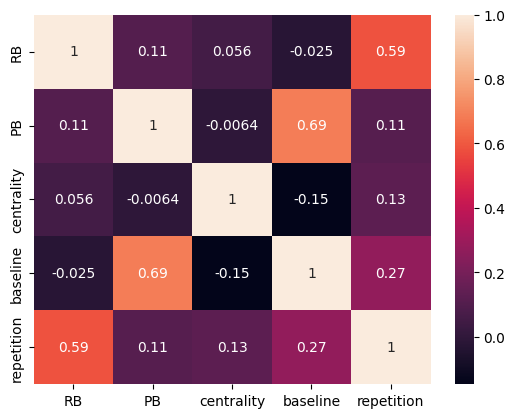

In [22]:
from matplotlib import pyplot as plt
import seaborn as sn

corr_matrix = prediction_comparison_table.corr(method="pearson")
sn.heatmap(corr_matrix, annot=True)
plt.show()


# Evaluation

- Using a projection on the author graph we can use the following centrality measures
    - closeness centrality
    - betweenness centrality
    - katz centrality

In [23]:
import psycopg2 as pg
import pandas.io.sql as psql
connection = pg.connect("host=localhost dbname=postgres user=postgres password=postgres")
metrics_query = "select conversation_id, twitter_id as author, platform, betweenness_centrality, closeness_centrality, katz_centrality from delab_conversationauthormetrics cam join delab_tweetauthor ta on ta.id = cam.author_id where katz_centrality > 0"

df_author_metrics = psql.read_sql(metrics_query, connection)

df_author_metrics.head(3)
# print(df_term_counts.head(8))

df_author_metrics_grouped = df_author_metrics.groupby(["platform", "conversation_id", "author_id"]).first()
df_author_metrics_grouped

/home/dehne/PycharmProjects/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


betweenness_centrality  \
platform conversation_id     author_id                                     
reddit   155266              538210                             0.289797   
                             3231623                            0.000000   
                             4228579                            0.141327   
                             5981722                            0.000000   
                             6182421                            0.000000   
...                                                                  ...   
twitter  1582370969402081281 958775881878724608                 0.000000   
                             1030834870296227840                0.000000   
                             1245698470985506817                0.000000   
                             1356511237249630208                0.000000   
         1582796197122965504 774684339087048705                 0.000000   

                                                  closeness_centrality  \
platform conversation_id     author_id                                   
reddit   155266              538210                           0.180133   
                             3231623                          0.119603   
                             4228579                          0.180133   
                             5981722                          0.167736   
                             6182421                          0.112741   
...                                                                ...   
twitter  1582370969402081281 958775881878724608               0.250000   
                             1030834870296227840              0.281250   
                             1245698470985506817              0.250000   
                             1356511237249630208              0.250000   
         1582796197122965504 774684339087048705               0.600000   

                                                  katz_centrality  
platform conversation_id     author_id                             
reddit   155266              538210                      0.188657  
                             3231623                     0.118359  
                             4228579                     0.173011  
                             5981722                     0.136065  
                             6182421                     0.130533  
...                                                           ...  
twitter  1582370969402081281 958775881878724608          0.321390  
                             1030834870296227840         0.357100  
                             1245698470985506817         0.321390  
                             1356511237249630208         0.321390  
         1582796197122965504 774684339087048705          0.488527  

[150023 rows x 3 columns]

In [35]:
prediction_comparison_table_final_2 = prediction_comparison_table_final.join(df_author_metrics_grouped)
prediction_comparison_table_final_2.describe()

,RB,PB,centrality,baseline,betweenness_centrality,closeness_centrality,katz_centrality
count,59016.000000,59016.000000,59016.000000,59016.000000,563.000000,563.000000,563.000000
mean,0.146624,0.001463,0.261623,0.492463,0.068418,0.226438,0.256252
std,0.012615,0.004449,0.100401,0.083753,0.151642,0.174263,0.105411
min,0.123510,0.000069,0.010101,0.220851,0.000000,0.000000,0.113101
25%,0.136750,0.000315,0.196330,0.442762,0.000000,0.110172,0.177908
50%,0.145766,0.000547,0.265522,0.503114,0.003268,0.175439,0.226677
75%,0.154707,0.001167,0.316667,0.527994,0.054724,0.293493,0.306895
max,0.186421,0.303938,0.557029,0.904283,1.000000,1.000000,0.707107


In [37]:
corr_matrix = prediction_comparison_table_final_2.corr(method="pearson")
# sn.heatmap(prediction_comparison_table_final_2, annot=True)
# plt.show()
corr_matrix


,RB,PB,centrality,baseline,betweenness_centrality,closeness_centrality,katz_centrality
RB,1.000000,0.003863,0.059685,-0.034952,0.193179,0.499482,0.686352
PB,0.003863,1.000000,-0.000458,0.036359,0.028605,0.094529,0.114085
centrality,0.059685,-0.000458,1.000000,-0.153327,0.061722,0.070858,-0.105923
baseline,-0.034952,0.036359,-0.153327,1.000000,0.001537,0.232594,0.181808
betweenness_centrality,0.193179,0.028605,0.061722,0.001537,1.000000,0.570921,0.468987
closeness_centrality,0.499482,0.094529,0.070858,0.232594,0.570921,1.000000,0.837374
katz_centrality,0.686352,0.114085,-0.105923,0.181808,0.468987,0.837374,1.000000


In [6]:
import pickle
file_name_PB = "data/conversation_mentions.pkl"
with open(file_name_PB, 'rb') as f:
    conversation_metrics = pickle.load(f)

conversation_ids_with_mentions = set(conversation_metrics.keys())
print("There are {} conversations with mentions".format(len(conversation_metrics)))

common_ids = set(common_conversation_ids).intersection(conversation_ids_with_mentions)
len(common_ids)

There are 3851 conversations with mentions


54